In [80]:
import pandas as pd
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import ast
from itertools import chain

from konlpy.tag import Okt

from collections import Counter
from wordcloud import WordCloud
import networkx as nx
from PIL import Image

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity


# 1. 데이터 불러오기

In [31]:
df = pd.read_csv(
    "../cocacoca0810/data/youtube_comments_origin.csv",
)

df.head()

,video_id,comment_id,comment_text,like_count,published_at
0,k5O1F_IS0mU,Ugykjh0_hVuTgqN8doR4AaABAg,그냥 얘들아 내가 진짜 ㅠ 애정한다 ㅠ 나 이렇게 애정해본 아이돌이 너네가 처음이고...,0,2026-01-31T15:59:29Z
1,k5O1F_IS0mU,Ugx1c4OKEnkVwGWBlFB4AaABAg,눈물이 난다,2,2026-01-23T04:29:25Z
2,k5O1F_IS0mU,UgwaAbmKOm2vwOgFEFp4AaABAg,이 노래도 겁나 좋네,2,2026-01-20T01:52:56Z
3,k5O1F_IS0mU,UgzquReVBuSocVLtI7t4AaABAg,"패러블, 이제 뉴세돌로 리와인드 다시 찍어 올려라!!! 이세돌 더 이쁜 버전으로 보...",3,2026-01-19T11:10:22Z
4,k5O1F_IS0mU,UgwM02x2Puib48rQTuF4AaABAg,언제 들어도 행복하고 좋은 노래..,2,2026-01-16T02:53:32Z


In [32]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 253125 entries, 0 to 253124
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   video_id      253125 non-null  str  
 1   comment_id    253125 non-null  str  
 2   comment_text  253004 non-null  str  
 3   like_count    253125 non-null  int64
 4   published_at  253125 non-null  str  
dtypes: int64(1), str(4)
memory usage: 9.7 MB


In [33]:
df[df["comment_text"].isna()]

,video_id,comment_id,comment_text,like_count,published_at
7234,rDFUl2mHIW4,Ugz3BCPtRQJkdc9Q-uV4AaABAg,NaN,6,2023-09-07T14:54:03Z
8629,rDFUl2mHIW4,UgwErp32xCRSWSjX8AB4AaABAg,NaN,6,2023-08-23T04:31:10Z
9593,rDFUl2mHIW4,UgzfCHYcXvZIORu989x4AaABAg,NaN,3,2023-08-21T03:24:04Z
15957,rDFUl2mHIW4,UgzAyjBkzbRQlvTH2314AaABAg,NaN,0,2023-08-18T10:19:32Z
16982,rDFUl2mHIW4,UgzAuoSB6sE6NCgqHdx4AaABAg,NaN,0,2023-08-18T09:33:10Z
...,...,...,...,...,...
240149,TVqEwvbZP30,UgzSFQgJLUtgL_w9JLx4AaABAg,NaN,4,2025-12-04T13:17:14Z
241036,TVqEwvbZP30,UgxMMrMaQAEJuEcP5Z54AaABAg,NaN,1,2025-11-30T17:34:53Z
248222,TVqEwvbZP30,Ugw0cXzQqlJLPQFPoFp4AaABAg,NaN,1,2025-11-24T15:11:09Z
248814,TVqEwvbZP30,UgziR42XLCSqHY5HThJ4AaABAg,NaN,1,2025-11-24T13:25:03Z


In [34]:
df = df.dropna()

In [35]:
df.info()

<class 'pandas.DataFrame'>
Index: 253004 entries, 0 to 253124
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   video_id      253004 non-null  str  
 1   comment_id    253004 non-null  str  
 2   comment_text  253004 non-null  str  
 3   like_count    253004 non-null  int64
 4   published_at  253004 non-null  str  
dtypes: int64(1), str(4)
memory usage: 11.6 MB


In [ ]:
# video_id별로 1000 개씩 랜덤 샘플링하기.

col = "video_id"
n_per_group = 1000
seed = 42

sampled_df = (
    df.groupby(col, group_keys=False)
      .apply(lambda g: g.assign(video_id=g.name)
             .sample(n=min(n_per_group, len(g)), random_state=seed))
      .reset_index(drop=True)
)

sampled_df.head()

,comment_id,comment_text,like_count,published_at,video_id
0,UgylsalvufMGVILXMjd4AaABAg,Gag🤟🤟,0,2023-09-07T10:55:39Z,3_b5oKGndn0
1,UgxZn2NFWHx-ddvmbgZ4AaABAg,❤❤❤,0,2023-09-07T11:09:41Z,3_b5oKGndn0
2,UgyVLyZTDPI1cO0TWjp4AaABAg,eunseok 😍😍,1,2023-09-08T04:38:09Z,3_b5oKGndn0
3,UgxWFgTCSsGhcxtR2VR4AaABAg,Briize? I just wanted us to be called the Rizz...,0,2023-09-07T11:16:39Z,3_b5oKGndn0
4,UgwxtQowkiT2RuQzUhd4AaABAg,Seunghan,0,2023-09-07T13:06:11Z,3_b5oKGndn0


In [ ]:
sampled_df.shape

(11000, 5)

# 2. Word Cloud

In [88]:
df = pd.read_csv(
    "../cocacoca0810/data/01_raw/subsets/Full_youtube_comments_nouns.csv",
)

df.columns.values[0] = 'video_id'

df.head()

,video_id,keywords
0,k5O1F_IS0mU,"['진짜', '애정', '애정', '아이돌', '처음', '콘서트', '아이돌', ..."
1,k5O1F_IS0mU,['눈물']
2,k5O1F_IS0mU,['노래']
3,k5O1F_IS0mU,"['패러블', '다시', '버전']"
4,k5O1F_IS0mU,"['언제', '노래']"


In [89]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 254516 entries, 0 to 254515
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   video_id  254516 non-null  str  
 1   keywords  70373 non-null   str  
dtypes: str(2)
memory usage: 3.9 MB


In [90]:
df = df.dropna()
df.info()

<class 'pandas.DataFrame'>
Index: 70373 entries, 0 to 254511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   video_id  70373 non-null  str  
 1   keywords  70373 non-null  str  
dtypes: str(2)
memory usage: 1.6 MB


In [109]:
df['video_id'].value_counts()

# 라이즈 영상에 단어 리스트가 133 밖에 없는걸 확인할 수 있다.

video_id
6ZUIwj3FgUY    20559
rDFUl2mHIW4    14962
EYG4ROejmyI    10109
8L001YT4k6k     7648
B1ShLiq3EVc     4733
T_gJpnjJsnk     3395
fff8P0kYexQ     2819
TVqEwvbZP30     2540
iUw3LPM7OBU     2076
k5O1F_IS0mU      967
bltjk6NfDQM      432
3_b5oKGndn0      133
Name: count, dtype: int64

In [ ]:
'''
8L001YT4k6k,PLAVE
EYG4ROejmyI,PLAVE
T_gJpnjJsnk,PLAVE
bltjk6NfDQM,IVE
B1ShLiq3EVc,IVE
6ZUIwj3FgUY,IVE
iUw3LPM7OBU,RIIZE
3_b5oKGndn0,RIIZE
TVqEwvbZP30,RIIZE
k5O1F_IS0mU,ISEGYE IDOL
rDFUl2mHIW4,ISEGYE IDOL
fff8P0kYexQ,ISEGYE IDOL
'''

In [ ]:
# 수작업함...
mask = df['video_id'].str.contains('fff8P0kYexQ')

df.loc[mask, 'group'] = 'ISEGYE IDOL'

In [108]:
df.head()

,video_id,keywords,group
0,k5O1F_IS0mU,"['진짜', '애정', '애정', '아이돌', '처음', '콘서트', '아이돌', ...",ISEGYE IDOL
1,k5O1F_IS0mU,['눈물'],ISEGYE IDOL
2,k5O1F_IS0mU,['노래'],ISEGYE IDOL
3,k5O1F_IS0mU,"['패러블', '다시', '버전']",ISEGYE IDOL
4,k5O1F_IS0mU,"['언제', '노래']",ISEGYE IDOL


In [107]:
df.info()

<class 'pandas.DataFrame'>
Index: 70373 entries, 0 to 254511
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   video_id  70373 non-null  str  
 1   keywords  70373 non-null  str  
 2   group     70373 non-null  str  
dtypes: str(3)
memory usage: 2.1 MB


In [114]:
# 각 그룹별 단어 리스트 개수
df['group'].value_counts()

group
IVE            25724
PLAVE          21152
ISEGYE IDOL    18748
RIIZE           4749
Name: count, dtype: int64

In [ ]:
# V와 R 나누기 위한 컬럼 추가
df['is_real'] = df['group'].str.contains(r'RIIZE|IVE', case=False)
df.head()

,video_id,keywords,group,is_real
0,k5O1F_IS0mU,"['진짜', '애정', '애정', '아이돌', '처음', '콘서트', '아이돌', ...",ISEGYE IDOL,False
1,k5O1F_IS0mU,['눈물'],ISEGYE IDOL,False
2,k5O1F_IS0mU,['노래'],ISEGYE IDOL,False
3,k5O1F_IS0mU,"['패러블', '다시', '버전']",ISEGYE IDOL,False
4,k5O1F_IS0mU,"['언제', '노래']",ISEGYE IDOL,False


In [129]:
# group별로 1000 개씩 랜덤 샘플링하기.

col = "group"
n_per_group = 4000
seed = 42

sampled_df = (
    df.groupby(col, group_keys=False)
      .apply(lambda g: g.assign(group=g.name)
             .sample(n=min(n_per_group, len(g)), random_state=seed))
      .reset_index(drop=True)
)

sampled_df.head()

,video_id,keywords,is_real,group
0,rDFUl2mHIW4,['씹덕'],False,ISEGYE IDOL
1,rDFUl2mHIW4,"['르르땅', '양갈래', '양갈래', '아이돌']",False,ISEGYE IDOL
2,rDFUl2mHIW4,['축하'],False,ISEGYE IDOL
3,fff8P0kYexQ,"['이프', '하미']",False,ISEGYE IDOL
4,rDFUl2mHIW4,"['맥도날드', '키딩']",False,ISEGYE IDOL


In [130]:
sampled_df.shape

(16000, 4)

In [131]:
sampled_df['group'].value_counts()

group
ISEGYE IDOL    4000
IVE            4000
PLAVE          4000
RIIZE          4000
Name: count, dtype: int64

In [155]:
sampled_real_df = sampled_df[sampled_df['is_real']]

In [156]:
# 개수 확인
sampled_real_df['is_real'].value_counts()

is_real
True    8000
Name: count, dtype: int64

In [147]:
col = "keywords"
word_list = []
stopwords = ['아이브', '라이즈', '진짜']

def parse_list_str(x):
    # NaN/None 방어
    if x is None:
        return []
    # 이미 list면 그대로
    if isinstance(x, list):
        return x
    # 문자열이면 리스트로 파싱 시도
    if isinstance(x, str):
        x = x.strip()
        if x == "" or x == "[]":
            return []
        try:
            v = ast.literal_eval(x)   # "['안녕']" -> ['안녕']
            return v if isinstance(v, list) else []
        except (ValueError, SyntaxError):
            return []  # 파싱 실패하면 빈 리스트로
    return []

sampled_real_df[col] = sampled_real_df[col].map(parse_list_str)

sampled_real_df[col].head()

4000                         [언니]
4001    [진짜, 신곡, 진짜, 레전드, 원영, 사랑]
4002                 [딸기, 테러, 원영]
4003                [무사, 아이브, 신곡]
4004                [마지막, 구두, 굽이]
Name: keywords, dtype: object

In [148]:
stop_set = set(stopwords)

word_list = [w for w in chain.from_iterable(sampled_real_df[col]) if w not in stop_set]

In [149]:
len(word_list)

28610

<>:3: DeprecationWarning: invalid escape sequence '\p'
<>:3: DeprecationWarning: invalid escape sequence '\p'
C:\Users\user\AppData\Local\Temp\ipykernel_26564\3103655349.py:3: DeprecationWarning: invalid escape sequence '\p'
  image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")


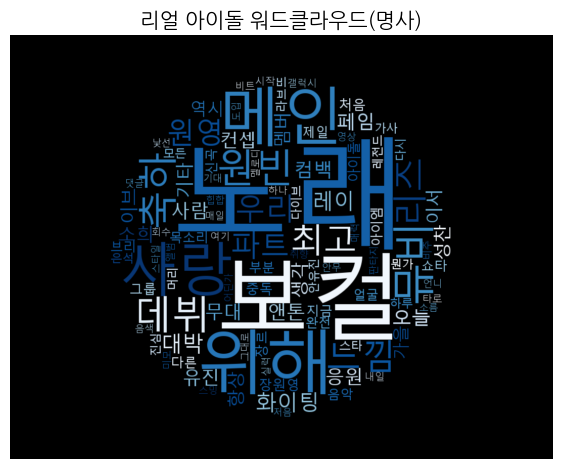

In [152]:
counter = Counter(word_list)

image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")
mask_img = np.array(image)

wc = WordCloud(
    font_path = "C:/Windows/Fonts/malgun.ttf",      # 중요!
    background_color="black",
    mask=mask_img,
    width=800,
    height=400,
    colormap="Blues"
)

wc.generate_from_frequencies(dict(counter.most_common(100)))

plt.figure(figsize=(7,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('리얼 아이돌 워드클라우드(명사)', fontsize=15)
plt.show()

In [157]:
sampled_virtual_df = sampled_df[~sampled_df['is_real']]

In [163]:
col = "keywords"
word_list = []
stopwords = ['플레이브', '이세돌', '진짜']

sampled_virtual_df[col] = sampled_virtual_df[col].map(parse_list_str)

sampled_virtual_df[col].head()

0                    [씹덕]
1    [르르땅, 양갈래, 양갈래, 아이돌]
2                    [축하]
3                [이프, 하미]
4              [맥도날드, 키딩]
Name: keywords, dtype: object

In [164]:
stop_set = set(stopwords)

word_list = [w for w in chain.from_iterable(sampled_virtual_df[col]) if w not in stop_set]

In [165]:
len(word_list)

31980

<>:3: DeprecationWarning: invalid escape sequence '\p'
<>:3: DeprecationWarning: invalid escape sequence '\p'
C:\Users\user\AppData\Local\Temp\ipykernel_26564\4256140342.py:3: DeprecationWarning: invalid escape sequence '\p'
  image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")


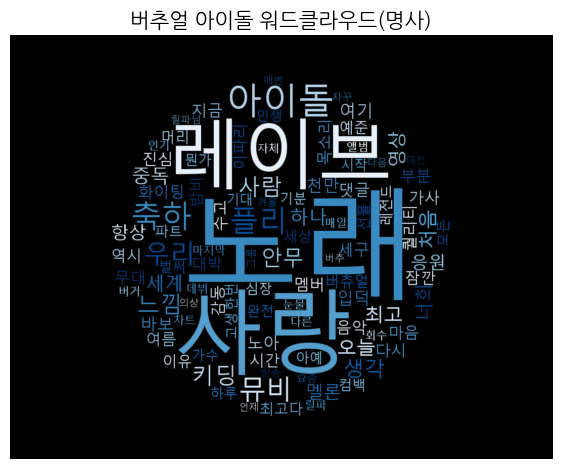

In [166]:
counter = Counter(word_list)

image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")
mask_img = np.array(image)

wc = WordCloud(
    font_path = "C:/Windows/Fonts/malgun.ttf",      # 중요!
    background_color="black",
    mask=mask_img,
    width=800,
    height=400,
    colormap="Blues"
)

wc.generate_from_frequencies(dict(counter.most_common(100)))

plt.figure(figsize=(7,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('버추얼 아이돌 워드클라우드(명사)', fontsize=15)
plt.show()

# 4. TF-IDF 벡터라이져

In [49]:
docs = [
    "기분이 좋다",
    "오늘 기분이 나쁘다",
    "날씨가 좋다"
]

# 1) TF-IDF (docs x terms)
vec = TfidfVectorizer()  # 한국어면 tokenizer를 형태소로 바꾸는 게 보통 더 좋음
X = vec.fit_transform(docs)
terms = vec.get_feature_names_out()


In [50]:
# 내용 ( 순서 정보는 없어짐 )
print(X.toarray())
[terms[np.where(x>0, True, False)] for x in X.toarray()]

[[0.70710678 0.         0.         0.         0.70710678]
 [0.4736296  0.62276601 0.         0.62276601 0.        ]
 [0.         0.         0.79596054 0.         0.60534851]]


[array(['기분이', '좋다'], dtype=object),
 array(['기분이', '나쁘다', '오늘'], dtype=object),
 array(['날씨가', '좋다'], dtype=object)]

In [46]:
X.toarray().shape[1]

5

# 5. CONCOR 분석 시각화 파일 만들기

In [ ]:
# 2-A) term x term cosine similarity
M_cos = cosine_similarity(X.T)  # (terms x terms)

# 2-B) term x term Pearson correlation (optional)
M_corr = np.corrcoef(X.toarray().T)  # (terms x terms)

# 원하는 걸 선택
M = M_cos  # or M_corr

# (선택) 대각선 처리: UCINET에서 보통 self-tie는 0 또는 1로 둠 (둘 다 가능)
np.fill_diagonal(M, 0.0)

dfM = pd.DataFrame(M, index=terms, columns=terms)

# 3) UCINET DL(fullmatrix)로 저장
def save_ucinet_dl_fullmatrix(df, path):
    labels = ", ".join(df.index.tolist())
    n = df.shape[0]
    with open(path, "w", encoding="CP949") as f:
        f.write(f"DL n={n}\n")
        f.write("format=fullmatrix\n")
        f.write("labels:\n")
        f.write(labels + "\n")
        f.write("data:\n")
        for row in df.values:
            f.write(" ".join(f"{v:.6f}" for v in row) + "\n")

save_ucinet_dl_fullmatrix(dfM, "word_similarity.dl")
print("Saved: word_similarity.dl")